# Word2vec Model

#### Fuente: Python Deep Learning Projects, curaduria para el presente curso

_______________________________________

In [ ]:
import requests
import os
import re
import multiprocessing

In [ ]:
import pandas as pd

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import nltk

In [ ]:
import gensim.models.word2vec as w2v

In [ ]:
import sklearn.manifold

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.contrib.tensorboard.plugins import projector

#### Para trabajar con este modelo es necesario bajar por unica vez estos modulos de NLTK

In [ ]:
#nltk.download("punkt")
#nltk.download("stopwords")

In [ ]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]", " ", raw)
    words = clean.split()
    return list(map(lambda x: x.lower(), words))

#### Preproceso a realizar con el texto

![Alt Text](./img/learning-word-vectors-1.png)

##### Texto extraido de Principles of Geology by Sir Charles Lyell, Project Gutenberg

In [ ]:
filepath = 'http://www.gutenberg.org/files/33224/33224-0.txt'
corpus_raw = requests.get(filepath).text

In [ ]:
# Clean text
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(corpus_raw)

In [ ]:
# Sentence where each word is tokenized
sentences = (sentence_to_wordlist(raw) for raw in raw_sentences if raw)
sentences = list(sentences)
token_count = sum([len(sentence) for sentence in sentences])
print(f'The book corpus contains {token_count} tokens.')

#### Definicion del Modelo

In [ ]:
print("AAA")

In [17]:
# Dimensiones
num_features = 300

# umbral minimo para considerar una palabra.
min_word_count = 3

# Definicon de tareas en paralelo
num_workers = multiprocessing.cpu_count()

# Ventana 
context_size = 7

# Bajada a disco
downsampling = 1e-3

# Semilla.
seed = 1

model2vec = w2v.Word2Vec(
    sg=1, seed=seed, workers=num_workers, size=num_features,
    min_count=min_word_count, window=context_size, sample=downsampling
)

In [18]:
model2vec.build_vocab(list(sentences))

***Nota:*** Aumentar el número de dimensiones conduce a una mejor generalización, pero también agrega más complejidad computacional

***Nota:*** Parametro ***context_size***. Establece el límite superior para la distancia entre la predicción de palabras actual y objetivo dentro de una oración.

#### Entrenamiento

In [6]:
model2vec.train(sentences, total_examples=model2vec.corpus_count, epochs=10)

if not os.path.exists(os.path.join('trained', 'sample')):
    os.makedirs(os.path.join('trained', 'sample'))

model2vec.save(os.path.join('trained', 'sample', 'sample.w2v'))

#### Evaluacion del modelo

In [19]:
print('Similar a: "earth":')
for sWord in model2vec.wv.most_similar("earth"):
    print(sWord)
    
print('\nSimilar a: "human":')
for sWord in model2vec.wv.most_similar("human"):
    print(sWord)
    
print('\nContribucion Positiva y Negativa:')
for sWord in model2vec.wv.most_similar_cosmul(positive=['earth', 'moon'], negative=['orbit']):
    print(sWord)

Similar a: "earth":
('distributed', 0.20546355843544006)
('morasses', 0.18450766801834106)
('drifted', 0.18013693392276764)
('mathematical', 0.17877432703971863)
('beobachtungen', 0.17356862127780914)
('thrust', 0.17302945256233215)
('mountains', 0.17165318131446838)
('or', 0.17156821489334106)
('exclusively', 0.1713852435350418)
('pursue', 0.16963011026382446)

Similar a: "human":
('ashes', 0.18397551774978638)
('divinity', 0.18094438314437866)
('commercial', 0.18037760257720947)
('visiting', 0.17990940809249878)
('conceives', 0.1794258952140808)
('august', 0.1793709695339203)
('conflict', 0.17706367373466492)
('pers', 0.17495974898338318)
('solitary', 0.17456170916557312)
('root', 0.17344947159290314)

Contribucion Positiva y Negativa:
('captain', 0.7029551863670349)
('steppes', 0.7002537250518799)
('fixes', 0.6999617218971252)
('rocks', 0.6949625611305237)
('provided', 0.6882278323173523)
('concealment', 0.6810541749000549)
('renewal', 0.6808697581291199)
('brackish', 0.680570542812

_______________________________________________________

### Representacion grafica 

Como se genero un espacio de 300 dimensiones para aprender las características, es dificil visualizarlo<br>
Se utiliza el algoritmo de reducción de dimensiones, llamado **t-SNE**.

***Distributed Stochastic Neighbor Embedding (t-SNE)*** es un algoritmo de aprendizaje automático para visualización, desarrollado por Laurens van der Maaten y Geoffrey Hinton.<br>
Técnica de reducción de dimensionalidad no lineal muy adecuada para incorporar datos de alta dimensión para visualización en un espacio de baja dimensión (dos o tres dimensiones) Wikipedia.

***Note:*** Este proceso de reduccion puede tmar mucho tiempo.

In [20]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [21]:
all_word_vectors_matrix = model2vec.wv.vectors

In [22]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

#### DataFrame par aguardar palabras y cordenadas

In [23]:
points = pd.DataFrame(
    [(word, coords[0], coords[1]) for word, coords in
        [(word, all_word_vectors_matrix_2d[model2vec.wv.vocab[word].index])
            for word in model2vec.wv.vocab]
     ],
    columns=["word", "x", "y"]
)

#### Graficar (425633 tokens en 2 dimensiones)

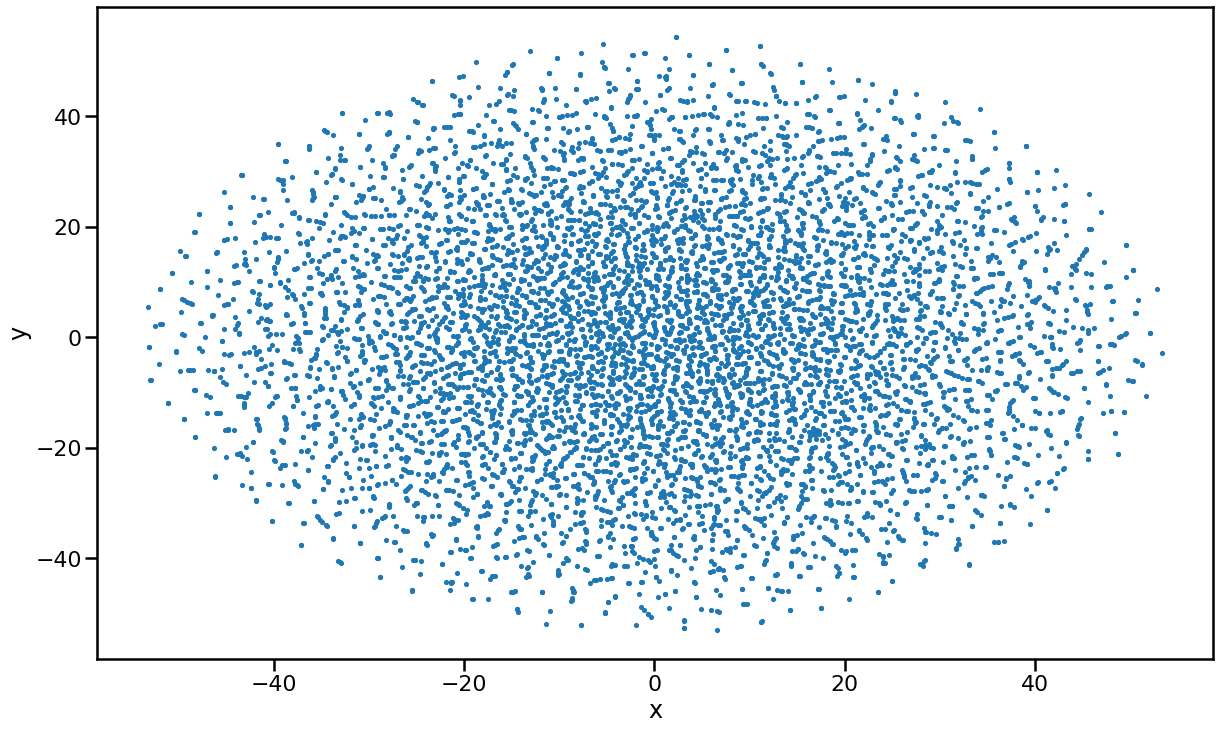

In [24]:
sns.set_context("poster")
ax = points.plot.scatter("x", "y", s=10, figsize=(20, 12))
fig = ax.get_figure()
plt.show()

In [25]:
points.head(10)

word          x          y
0         the  -9.041798 -40.230141
1     project -17.757553  -3.870029
2   gutenberg -34.618935  37.419662
3       ebook   8.277767  18.537155
4          of  13.537230  -2.380185
5  principles   3.219845  19.933344
6     geology  -3.017742  29.480667
7          by   2.199642 -13.834626
8     charles   4.474695  11.553845
9       lyell  11.753339  39.729378

____________________________________________________

### Tensorboard

In [12]:
vocab_list = points.word.values.tolist()
embeddings = all_word_vectors_matrix

embedding_var = tf.Variable(all_word_vectors_matrix, dtype='float32', name='embedding')

projector_config = projector.ProjectorConfig()
embedding = projector_config.embeddings.add()
embedding.tensor_name = embedding_var.name

LOG_DIR = './'
metadata_file = os.path.join("sample.tsv")

with open(os.path.join(LOG_DIR, metadata_file), 'wt') as metadata:
    metadata.writelines("%s\n" % w.encode('utf-8') for w in vocab_list)

embedding.metadata_path = os.path.join(os.getcwd(), metadata_file)

summary_writer = tf.summary.FileWriter(LOG_DIR)

projector.visualize_embeddings(summary_writer, projector_config)

saver = tf.train.Saver([embedding_var])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.save(sess, os.path.join(LOG_DIR, metadata_file+'.ckpt'))

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
tensorboard --logdir=./